# 26. OpenAI Whisper를 활용한 영상 요약

## 프로젝트 개요

이 노트북은 영상 파일에서 음성을 추출하고, OpenAI Whisper를 사용하여 텍스트로 변환한 후, 내용을 요약하여 Notion 데이터베이스에 자동으로 업로드하는 시스템을 구축합니다.

### 주요 기능
1. **영상 파일 처리**: 음성 추출 및 텍스트 변환
2. **자동 요약**: AI를 활용한 영상 내용 요약 및 아웃라인 생성  
3. **Notion 연동**: 처리된 내용을 자동으로 Notion 데이터베이스에 저장

### 사용 기술
- OpenAI Whisper: 음성-텍스트 변환
- LangGraph: 워크플로우 관리
- OpenAI GPT: 텍스트 요약
- Notion API: 데이터 저장



## 1. 환경 설정


In [ ]:
# 환경 변수 로드 - OpenAI API 키와 Notion API 키를 .env 파일에서 불러옵니다
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv()

True

## 2. 워크플로우 상태 정의

LangGraph에서 사용할 상태 구조를 정의합니다. 이 상태는 전체 워크플로우에서 데이터가 어떻게 흘러가는지 관리합니다.


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

# 워크플로우에서 사용할 상태 구조 정의
class AgentState(TypedDict):
    file_path: str      # 처리할 영상 파일 경로
    transcript: str     # Whisper로 추출한 텍스트
    outline: str        # 생성된 아웃라인
    title: str          # 영상/문서 제목
    database_id: str    # Notion 데이터베이스 ID
    
# 상태 그래프 빌더 초기화
graph_builder = StateGraph(AgentState)

## 3. AI 모델 초기화

OpenAI의 ChatGPT와 Whisper 모델을 초기화합니다. 이 모델들은 각각 텍스트 요약과 음성-텍스트 변환에 사용됩니다.


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

# ChatGPT 모델 초기화 - 텍스트 요약과 아웃라인 생성에 사용
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # temperature=0으로 설정하여 일관된 결과 생성

# Whisper 파서 초기화 - 음성/영상 파일에서 텍스트 추출에 사용
audio_parser = OpenAIWhisperParser()

## 4. 워크플로우 노드 함수 정의

### 4.1 트랜스크립트 추출 함수

영상 파일에서 OpenAI Whisper를 사용하여 음성을 텍스트로 변환하는 함수입니다.


In [ ]:
from langchain_core.documents.base import Blob
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

def extract_transcript(state: AgentState) -> AgentState:
    """
    영상 파일에서 음성을 추출하여 텍스트로 변환하는 함수
    """
    # 상태에서 파일 경로 가져오기
    file_path = state["file_path"]
    
    # 파일을 Blob 객체로 변환 (Whisper가 처리할 수 있는 형태)
    audio_blob = Blob(path=file_path)
    
    # Whisper를 사용하여 음성을 텍스트로 변환
    documents = audio_parser.lazy_parse(audio_blob)
    
    # 변환된 텍스트들을 하나의 문자열로 결합
    transcript = ""
    for doc in documents:
        transcript += doc.page_content
    
    # 결과를 상태로 반환
    return {"transcript": transcript}

### 4.2 아웃라인 생성 함수

추출된 텍스트를 바탕으로 ChatGPT를 사용하여 한국어 아웃라인을 생성하는 함수입니다.


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 아웃라인 생성용 모델 (더 정확한 결과를 위해 gpt-4o 사용)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def generate_outline(state: AgentState) -> AgentState:
    """
    추출된 텍스트를 바탕으로 한국어 아웃라인을 생성하는 함수
    """
    # 상태에서 트랜스크립트 가져오기
    transcript = state["transcript"]
    
    # 아웃라인 생성을 위한 프롬프트 템플릿 설정
    outline_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that generates an outline for a transcript. Make sure to use Korean when you generate the outline."),
        ("user", "Generate an outline for the following transcript: {transcript}"),
    ])
    
    # 체인 구성: 프롬프트 -> LLM -> 문자열 파서
    outline_chain = outline_prompt | llm | StrOutputParser()
    
    # 아웃라인 생성
    outline = outline_chain.invoke({"transcript": transcript})
    
    # 결과를 상태로 반환
    return {"outline": outline}

### 4.3 Notion 업로드 함수

생성된 아웃라인을 Notion 데이터베이스에 새로운 페이지로 업로드하는 함수입니다.


In [ ]:
import requests
import os

def upload_to_notion(state: AgentState) -> AgentState:
    """
    생성된 아웃라인을 Notion 데이터베이스에 업로드하는 함수
    """
    # 상태에서 필요한 정보 가져오기
    database_id = state['database_id']  # Notion 데이터베이스 ID
    title = state['title']              # 페이지 제목
    outline = state['outline']          # 생성된 아웃라인
    
    # 환경 변수에서 Notion API 키 가져오기
    notion_api_key = os.getenv("NOTION_API_KEY")
    
    # Notion API 요청 헤더 설정
    headers = {
        'Authorization': f'Bearer {notion_api_key}',
        'Content-Type': 'application/json',
        'Notion-Version': '2022-06-28'  # Notion API 버전 지정
    }
    
    # 새 페이지 생성을 위한 데이터 구성
    data = {
        'parent': {'database_id': database_id},  # 부모 데이터베이스 지정
        'properties': {
            'Title': {'title': [{'text': {'content': title}}]},  # 페이지 제목 설정
        },
        'children': [
            {
                'object': 'block',
                'type': 'paragraph',
                'paragraph': {'rich_text': [{'type': 'text', 'text': {'content': outline}}]},  # 아웃라인 내용 추가
            }
        ]
    }
    
    # Notion API에 페이지 생성 요청
    response = requests.post(
        'https://api.notion.com/v1/pages',
        headers=headers,
        json=data
    )
    
    # 응답 결과 출력
    print(response.json())
    return {}

## 5. 워크플로우 그래프 구성

### 5.1 노드 추가

정의한 함수들을 그래프의 노드로 추가합니다.


In [ ]:
# 워크플로우 그래프에 노드 추가
graph_builder.add_node(extract_transcript)  # 트랜스크립트 추출 노드
graph_builder.add_node(generate_outline)    # 아웃라인 생성 노드
graph_builder.add_node(upload_to_notion)    # Notion 업로드 노드

### 5.2 워크플로우 엣지 연결 및 그래프 컴파일

노드들 간의 실행 순서를 정의하고 그래프를 컴파일합니다.


In [ ]:
from langgraph.graph import START, END

# 워크플로우 실행 순서 정의 (엣지 연결)
graph_builder.add_edge(START, 'extract_transcript')                   # 시작 → 트랜스크립트 추출
graph_builder.add_edge('extract_transcript', 'generate_outline')      # 트랜스크립트 추출 → 아웃라인 생성
graph_builder.add_edge('generate_outline', 'upload_to_notion')        # 아웃라인 생성 → Notion 업로드
graph_builder.add_edge('upload_to_notion', END)                       # Notion 업로드 → 종료

# 그래프 컴파일 (실행 가능한 상태로 변환)
graph = graph_builder.compile()

## 6. 워크플로우 시각화

구성된 워크플로우를 시각적으로 확인할 수 있습니다.


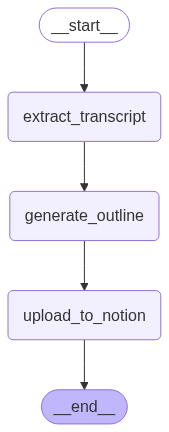

In [ ]:
# 워크플로우 그래프 시각화
graph

## 7. 워크플로우 실행

실제 영상 파일을 처리하여 전체 워크플로우를 실행합니다.

### 실행 파라미터
- `file_path`: 처리할 영상 파일 경로
- `database_id`: Notion 데이터베이스 ID
- `title`: 생성될 페이지 제목

### 실행 순서
1. 영상 파일에서 음성 추출 및 텍스트 변환
2. 추출된 텍스트를 바탕으로 한국어 아웃라인 생성
3. 생성된 아웃라인을 Notion 데이터베이스에 업로드


In [ ]:
# 워크플로우 실행
# 영상 파일 경로, Notion 데이터베이스 ID, 제목을 설정하여 전체 프로세스 실행
graph.invoke({
    "file_path": "./videos/news_scrap_with_naver.mp4",  # 처리할 영상 파일 경로
    "database_id": "22fe40c477c5806798a7f51edc0ab976",  # Notion 데이터베이스 ID
    "title": "Naver에서 뉴스 스크랩"                      # 페이지 제목
})

Transcribing part 1!
Transcribing part 2!
{'object': 'page', 'id': '22fe40c4-77c5-81e2-8617-eda78a5ce5c5', 'created_time': '2025-07-13T09:15:00.000Z', 'last_edited_time': '2025-07-13T09:15:00.000Z', 'created_by': {'object': 'user', 'id': 'afb99aa5-48e7-4e20-b8ea-e9c736064885'}, 'last_edited_by': {'object': 'user', 'id': 'afb99aa5-48e7-4e20-b8ea-e9c736064885'}, 'cover': None, 'icon': None, 'parent': {'type': 'database_id', 'database_id': '22fe40c4-77c5-8067-98a7-f51edc0ab976'}, 'archived': False, 'in_trash': False, 'properties': {'Title': {'id': 'title', 'type': 'title', 'title': [{'type': 'text', 'text': {'content': 'Naver에서 뉴스 스크랩', 'link': None}, 'annotations': {'bold': False, 'italic': False, 'strikethrough': False, 'underline': False, 'code': False, 'color': 'default'}, 'plain_text': 'Naver에서 뉴스 스크랩', 'href': None}]}}, 'url': 'https://www.notion.so/Naver-22fe40c477c581e28617eda78a5ce5c5', 'public_url': None, 'request_id': 'b296147e-547d-4f3a-8def-18d17a41313e'}


{'file_path': './videos/news_scrap_with_naver.mp4',
 'transcript': '하나 둘 셋 네 다음은 네이버에서 한번 뉴스를 긁어오보겠습니다 제가 사실 이걸 할까 말까 조금 망설였던 게 그 네이버에서 뉴스를 하나 둘 셋 네이버에서 뉴스를 긁어오는게 쉽지가 않더라구요 왜냐면 검색을 한번 해보면 여기 자세히 보세요 이게 무한 스크롤 이거든요 그래서 흔히 그냥 1,2 눌러서는 페이지네이션이 안되는 거예요 그래서 이걸 어떻게 해야되냐면 새로 취한 번 하고 개발자 도구를 열어서 네트워크 탭에 가서 스크롤을 하면 여기 모어 보이시나요 모어? 이게 그 정보예요 여기 URL이 뉴스리스트를 가져오는 거에요 리스판스를 딱 보면 여기 URL이 다음 페이지 거든요 보시면은 스타트라는 쿼리 파라미터가 있어요 좀만 기다려주세요 여기 다음 URL은 스타트가 21 그리고 지금 URL은 스타트가 11 그쵸? 그래서 요거를 복사해다가 탭을 열고 스타트를 1로 바꿔주면 이게 우리가 처음 불러오는 뉴스리스트인거에요 그러면 여기로 와서 트리거를 추가하고 오너 스케줄 한 다음에 여기는 HTTP 노드가 있습니다 얘를 추가해서 URL에 넣어주면 긁어오죠 그쵸? 그리고 여기 옵션에 보면 페이지 네이션이 있어요 그래서 요거를 넣어 줘야 되는데 리스판스는 왠지 모르게 안 긁어져 오더라구요 그래서 리스판스 컨테인스 넥스트 URL 리스판스에 넥스트 URL이 있다 선택하시고 얘는 변수로 익스프레션 한 다음에 리스판스 점 바디에 URL 그러면은 다음게 들어가죠 그런 다음에 이게 무한 스크롤이잖아요 안 끝나거든요 그래서 리밋을 해줘야 돼요 뭐 한 10개 정도로 이렇게 그리고 인터벌비트윈도 넣어 줄게요 한 500 밀리 세컨드 해줄까요 아 근데 이거는 사실 막 정하는 것보다는 여기 로보트 다 TXT 라고 있는데 여기에 크롤링 정보가 들어가 있어요 상관이 없네요 가끔 여기에 그 딜레이가 적혀 있는 경우가 있거든요 그러 아 이게 방금 하나 둘 셋 이게 지금 다운받은 로봇 다 TXT

## 프로젝트 완료

이 워크플로우를 통해 영상 파일을 자동으로 처리하여 다음과 같은 결과를 얻을 수 있습니다:

1. **음성 인식**: OpenAI Whisper를 통한 정확한 음성-텍스트 변환
2. **내용 요약**: ChatGPT를 활용한 구조적인 한국어 아웃라인 생성
3. **자동 저장**: Notion 데이터베이스에 자동 업로드

### 활용 방안
- 온라인 강의 내용 요약
- 회의록 자동 생성
- 인터뷰 내용 정리
- 팟캐스트 요약

### 주의사항
- OpenAI API 키와 Notion API 키가 `.env` 파일에 설정되어 있어야 합니다
- 영상 파일은 Whisper가 지원하는 형식이어야 합니다 (mp4, mp3, wav 등)
- Notion 데이터베이스에 적절한 권한이 설정되어 있어야 합니다

### 환경 변수 설정 예시
```
OPENAI_API_KEY=your_openai_api_key_here
NOTION_API_KEY=your_notion_integration_secret_here
```
